In [1]:
import time
import sys
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from dataset import ImageDataset
import torch.nn.functional as F
from torchmetrics import Precision, Recall
from torchvision.models import resnet18
import warnings
from collections import defaultdict
import wandb
import datetime
import os
from vit.vit import VisionTransformer
warnings.filterwarnings('ignore')
torch.set_float32_matmul_precision('high')


run_name = f'VIT_{datetime.datetime.now()}'
run_path = f'training_checkpoints/{run_name}'

wandb.init(project="cells", 
           entity="adamsoja",
          name=run_name)

import random
random.seed(2233)
torch.manual_seed(2233)

from albumentations import (
    Compose,
    Resize,
    OneOf,
    RandomBrightness,
    RandomContrast,
    MotionBlur,
    MedianBlur,
    GaussianBlur,
    VerticalFlip,
    HorizontalFlip,
    ShiftScaleRotate,
    Normalize,
)

transform = Compose(
    [
        OneOf([RandomBrightness(limit=0.4, p=1), RandomContrast(limit=0.4, p=1)]),
        OneOf([MotionBlur(blur_limit=3), MedianBlur(blur_limit=3), GaussianBlur(blur_limit=3),], p=0.7,),
        VerticalFlip(p=0.5),
        HorizontalFlip(p=0.5),]
)

class MyModel(nn.Module):
    def __init__(self, model, learning_rate, weight_decay):
        super(MyModel, self).__init__()
        self.model = model
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay
        self.criterion = nn.CrossEntropyLoss()
        self.metric_precision = Precision(task="multiclass", num_classes=4, average=None).to('cuda')
        self.metric_recall = Recall(task="multiclass", num_classes=4, average=None).to('cuda')
        self.train_loss = []
        self.valid_loss = []
        self.precision_per_epochs = []
        self.recall_per_epochs = []

        self.optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
        self.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(self.optimizer, mode="min", factor=0.1, patience=2, min_lr=5e-6, verbose=True)
        self.step = 0

    
    def forward(self, x):
        return self.model(x)

    def train_one_epoch(self, trainloader):
        self.step += 1
        self.train()
        for batch_idx, (inputs, labels) in enumerate(trainloader):
            inputs, labels = inputs.to('cuda'), labels.to('cuda')
            self.optimizer.zero_grad()
            outputs = self.model(inputs)
            loss = self.criterion(outputs, labels)
            loss.backward()
            self.optimizer.step()
            _, preds = torch.max(outputs, 1)
            _, labels = torch.max(labels, 1)
            self.metric_precision(preds, labels)
            self.metric_recall(preds, labels)
            self.train_loss.append(loss.item())


        

        
        avg_loss = np.mean(self.train_loss)
        self.train_loss.clear()
        precision = self.metric_precision.compute()
        recall = self.metric_recall.compute()
        self.precision_per_epochs.append(precision)
        self.recall_per_epochs.append(recall)
        print(f'train_loss: {avg_loss}')
        print(f'train_precision: {precision}')
        print(f'train_recall: {recall}')

        wandb.log({'loss': avg_loss},step=self.step)
        wandb.log({'Normal precision': precision[0].item()},step=self.step)
        wandb.log({'Inflamatory precision': precision[1].item()},step=self.step)
        wandb.log({'Tumor precision': precision[2].item()},step=self.step)
        wandb.log({'Other precision': precision[3].item()},step=self.step)


        wandb.log({'Normal recall': recall[0].item()},step=self.step)
        wandb.log({'Inflamatory recall': recall[1].item()},step=self.step)
        wandb.log({'Tumor recall': recall[2].item()},step=self.step)
        wandb.log({'Other recall': recall[3].item()},step=self.step)
        
        
        self.metric_precision.reset()
        self.metric_recall.reset()


    

    def evaluate(self, testloader):
        self.eval()
        with torch.no_grad():
            for batch_idx, (inputs, labels) in enumerate(testloader):
                inputs, labels = inputs.to('cuda'), labels.to('cuda')
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)
                _, preds = torch.max(outputs, 1)
                _, labels = torch.max(labels, 1)
                self.metric_precision(preds, labels)
                self.metric_recall(preds, labels)
                self.valid_loss.append(loss.item())
    
        avg_loss = np.mean(self.valid_loss)
        self.scheduler.step(avg_loss)
        self.valid_loss.clear()
        precision = self.metric_precision.compute()
        recall = self.metric_recall.compute()
        print(f'val_loss: {avg_loss}')
        print(f'val_precision: {precision}')
        print(f'val_recall: {recall}')
        self.metric_precision.reset()
        self.metric_recall.reset()

        wandb.log({'val_loss': avg_loss}, step=self.step)
        
        wandb.log({'val_Normal precision': precision[0].item()},step=self.step)
        wandb.log({'val_Inflamatory precision': precision[1].item()},step=self.step)
        wandb.log({'val_Tumor precision': precision[2].item()},step=self.step)
        wandb.log({'val_Other precision': precision[3].item()},step=self.step)


        wandb.log({'val_Normal recall': recall[0].item()},step=self.step)
        wandb.log({'val_Inflamatory recall': recall[1].item()},step=self.step)
        wandb.log({'val_Tumor recall': recall[2].item()},step=self.step)
        wandb.log({'val_Other recall': recall[3].item()},step=self.step)


        for param_group in self.optimizer.param_groups:
            print(f"Learning rate: {param_group['lr']}")
        return avg_loss

torch.cuda.empty_cache()
batch_size = 256
trainset = ImageDataset(data_path='train_data', transform=transform)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=5)

testset = ImageDataset(data_path='validation_data')
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=3)

learning_rate = 0.001
weight_decay = 0.00001

model = VisionTransformer(image_size=32, in_channels=3, num_classes=4, hidden_dims=[128, 128], dropout_rate=0.6)
model = model.to('cuda')


my_model = MyModel(model=model, learning_rate=learning_rate, weight_decay=weight_decay)
my_model = my_model.to('cuda')

num_epochs = 100
early_stop_patience = 10
best_val_loss = float('inf')
best_model_state_dict = None

for epoch in range(num_epochs):
    print('========================================')
    print(f'EPOCH: {epoch}') 
    time_start = time.perf_counter()
    my_model.train_one_epoch(trainloader)
    val_loss = my_model.evaluate(testloader)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state_dict = my_model.state_dict()
        torch.save(best_model_state_dict, f'{run_path}.pth')
        
        patience_counter = 0
    else:
        patience_counter += 1

    if patience_counter >= early_stop_patience:
        print(f"Early stopping at epoch {epoch} with best validation loss {best_val_loss}")
        break
    time_epoch = time.perf_counter() - time_start
    print(f'epoch {epoch} time:  {time_epoch/60}')
    print('--------------------------------')

# Load the best model state dict
print(f'{run_path}.pth')
my_model.load_state_dict(torch.load(f'{run_path}.pth'))
print(f'{run_path}.pth')

wandb: Currently logged in as: adamsoja. Use `wandb login --relogin` to force relogin


EPOCH: 0
train_loss: 1.088956790240038
train_precision: tensor([0.4081, 0.4758, 0.4408, 0.0000], device='cuda:0')
train_recall: tensor([0.3653, 0.5611, 0.4522, 0.0000], device='cuda:0')
val_loss: 0.9357386310895284
val_precision: tensor([0.6368, 0.6639, 0.5634, 0.0000], device='cuda:0')
val_recall: tensor([0.3398, 0.7739, 0.7891, 0.0000], device='cuda:0')
Learning rate: 0.001
epoch 0 time:  1.8627817309999954
--------------------------------
EPOCH: 1
train_loss: 1.0374562854568163
train_precision: tensor([0.4509, 0.5056, 0.4765, 0.4792], device='cuda:0')
train_recall: tensor([0.4158, 0.5589, 0.5108, 0.0033], device='cuda:0')
val_loss: 1.021215814103683
val_precision: tensor([0.5489, 0.8188, 0.4996, 0.3122], device='cuda:0')
val_recall: tensor([0.3227, 0.5619, 0.8937, 0.1158], device='cuda:0')
Learning rate: 0.001
epoch 1 time:  1.4568302506333415
--------------------------------
EPOCH: 2
train_loss: 1.0165115782192775
train_precision: tensor([0.4591, 0.5105, 0.4941, 0.5731], device='cu

In [2]:
from sklearn.metrics import confusion_matrix, classification_report
from torch.utils.data import DataLoader
import numpy as np
import torch 
from torchvision.models import resnet18
import torch.nn as nn


def test_report(model, dataloader):
    """Prints confusion matrix for testing dataset
    dataloader should be of batch_size=1."""

    y_pred = []
    y_test = []
    model.eval()
    with torch.no_grad():
        for data, label in dataloader:
            output = model(data)
            label = label.numpy()
            output = output.numpy()
            y_pred.append(np.argmax(output))
            y_test.append(np.argmax(label))
        print(confusion_matrix(y_test, y_pred))
        print(classification_report(y_test, y_pred))

testset =ImageDataset(data_path='test_data')
dataloader = DataLoader(testset, batch_size=1, shuffle=True)

test_report(my_model.to('cpu'), dataloader)

[[651 135 204  10]
 [ 94 867  35   4]
 [149  81 763   7]
 [ 17  21  14  48]]
              precision    recall  f1-score   support

           0       0.71      0.65      0.68      1000
           1       0.79      0.87      0.82      1000
           2       0.75      0.76      0.76      1000
           3       0.70      0.48      0.57       100

    accuracy                           0.75      3100
   macro avg       0.74      0.69      0.71      3100
weighted avg       0.75      0.75      0.75      3100



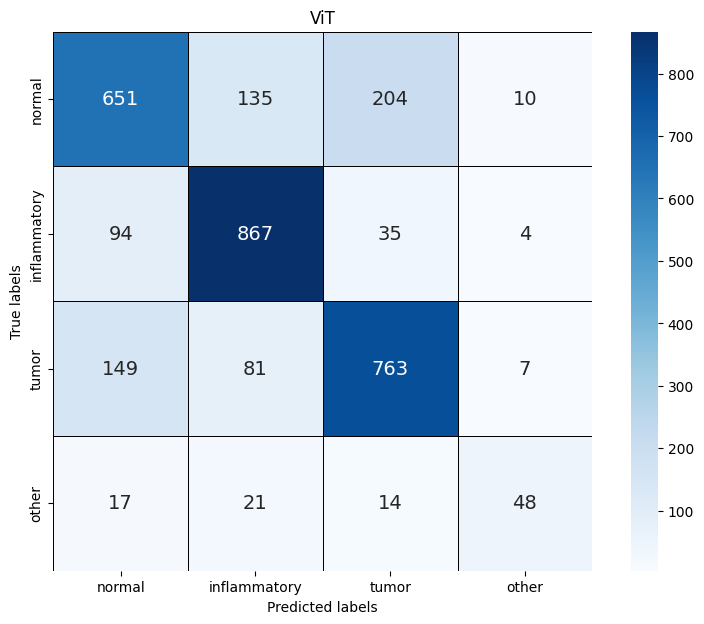

In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Define the confusion matrix
confusion_matrix = np.array([
    [651, 135, 204,  10],
    [ 94, 867,  35,   4],
    [149,  81, 763,   7],
    [ 17,  21,  14,  48]
])

# Define labels for the heatmap
labels = ['normal', 'inflammatory', 'tumor', 'other']

# Create a heatmap with larger text annotations and axis labels
plt.figure(figsize=(10, 7))
ax = sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues',
                 cbar=True, square=True, linewidths=0.5, linecolor='black',
                 annot_kws={"size": 14},  # Increase text size here
                 xticklabels=labels,  # Set x-axis labels
                 yticklabels=labels)  # Set y-axis labels

# Set labels and title
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('ViT')

# Show the plot
plt.show()


In [ ]:
import time
import sys
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from dataset import ImageDataset
import torch.nn.functional as F
from torchmetrics import Precision, Recall
from torchvision.models import resnet18
import warnings
from collections import defaultdict
import wandb
import datetime
import os

warnings.filterwarnings('ignore')
torch.set_float32_matmul_precision('high')
#intecubic interpol

run_name = f'dinov2_42x42_1024batch{datetime.datetime.now()}'
run_path = f'training_checkpoints/{run_name}'

wandb.init(project="cells", 
           entity="adamsoja",
          name=run_name)

import random
random.seed(2233)
torch.manual_seed(2233)

#After /255 so in loading dataset there are no division by 255 just this normalization
mean = [0.5005, 0.3526, 0.5494]
std = [0.1493, 0.1340, 0.1123]


from albumentations import (
    Compose,
    Resize,
    OneOf,
    RandomBrightness,
    RandomContrast,
    MotionBlur,
    MedianBlur,
    GaussianBlur,
    VerticalFlip,
    HorizontalFlip,
    ShiftScaleRotate,
    Normalize,
)

transform = Compose(
    [
        Normalize(mean=mean, std=std),
        OneOf([RandomBrightness(limit=0.4, p=1), RandomContrast(limit=0.4, p=1)]),
        OneOf([MotionBlur(blur_limit=3), MedianBlur(blur_limit=3), GaussianBlur(blur_limit=3),], p=0.7,),
        VerticalFlip(p=0.5),
        HorizontalFlip(p=0.5),]
)



transform_test = Compose(
    [Normalize(mean=mean, std=std)]
)

class MyModel(nn.Module):
    def __init__(self, model, learning_rate, weight_decay):
        super(MyModel, self).__init__()
        self.model = model
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay
        self.criterion = nn.CrossEntropyLoss()
        self.metric_precision = Precision(task="multiclass", num_classes=4, average=None).to('cuda')
        self.metric_recall = Recall(task="multiclass", num_classes=4, average=None).to('cuda')
        self.train_loss = []
        self.valid_loss = []
        self.precision_per_epochs = []
        self.recall_per_epochs = []

        self.optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
        self.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(self.optimizer, mode="min", factor=0.005, patience=2, min_lr=5e-6, verbose=True)
        self.step = 0

    
    def forward(self, x):
        return self.model(x)

    def train_one_epoch(self, trainloader):
        self.step += 1
        self.train()
        for batch_idx, (inputs, labels) in enumerate(trainloader):
            inputs, labels = inputs.to('cuda'), labels.to('cuda')
            self.optimizer.zero_grad()
            outputs = self.model(inputs)
            loss = self.criterion(outputs, labels)
            loss.backward()
            self.optimizer.step()
            _, preds = torch.max(outputs, 1)
            _, labels = torch.max(labels, 1)
            self.metric_precision(preds, labels)
            self.metric_recall(preds, labels)
            self.train_loss.append(loss.item())


        

        
        avg_loss = np.mean(self.train_loss)
        self.train_loss.clear()
        precision = self.metric_precision.compute()
        recall = self.metric_recall.compute()
        self.precision_per_epochs.append(precision)
        self.recall_per_epochs.append(recall)
        print(f'train_loss: {avg_loss}')
        print(f'train_precision: {precision}')
        print(f'train_recall: {recall}')

        wandb.log({'loss': avg_loss},step=self.step)
        wandb.log({'Normal precision': precision[0].item()},step=self.step)
        wandb.log({'Inflamatory precision': precision[1].item()},step=self.step)
        wandb.log({'Tumor precision': precision[2].item()},step=self.step)
        wandb.log({'Other precision': precision[3].item()},step=self.step)


        wandb.log({'Normal recall': recall[0].item()},step=self.step)
        wandb.log({'Inflamatory recall': recall[1].item()},step=self.step)
        wandb.log({'Tumor recall': recall[2].item()},step=self.step)
        wandb.log({'Other recall': recall[3].item()},step=self.step)
        
        
        self.metric_precision.reset()
        self.metric_recall.reset()


    

    def evaluate(self, testloader):
        self.eval()
        with torch.no_grad():
            for batch_idx, (inputs, labels) in enumerate(testloader):
                inputs, labels = inputs.to('cuda'), labels.to('cuda')
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)
                _, preds = torch.max(outputs, 1)
                _, labels = torch.max(labels, 1)
                self.metric_precision(preds, labels)
                self.metric_recall(preds, labels)
                self.valid_loss.append(loss.item())
    
        avg_loss = np.mean(self.valid_loss)
        self.scheduler.step(avg_loss)
        self.valid_loss.clear()
        precision = self.metric_precision.compute()
        recall = self.metric_recall.compute()
        print(f'val_loss: {avg_loss}')
        print(f'val_precision: {precision}')
        print(f'val_recall: {recall}')
        self.metric_precision.reset()
        self.metric_recall.reset()

        wandb.log({'val_loss': avg_loss}, step=self.step)
        
        wandb.log({'val_Normal precision': precision[0].item()},step=self.step)
        wandb.log({'val_Inflamatory precision': precision[1].item()},step=self.step)
        wandb.log({'val_Tumor precision': precision[2].item()},step=self.step)
        wandb.log({'val_Other precision': precision[3].item()},step=self.step)


        wandb.log({'val_Normal recall': recall[0].item()},step=self.step)
        wandb.log({'val_Inflamatory recall': recall[1].item()},step=self.step)
        wandb.log({'val_Tumor recall': recall[2].item()},step=self.step)
        wandb.log({'val_Other recall': recall[3].item()},step=self.step)


        for param_group in self.optimizer.param_groups:
            print(f"Learning rate: {param_group['lr']}")
        return avg_loss

torch.cuda.empty_cache()
batch_size = 256

trainset = ImageDataset(data_path='train_data', transform=transform)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=3)

testset = ImageDataset(data_path='validation_data', transform=transform_test)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)


learning_rate = 0.001
weight_decay = 0.00001
model = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14_lc')
model.linear_head = nn.Linear(1920, 4)
model = model.to('cuda')


my_model = MyModel(model=model, learning_rate=learning_rate, weight_decay=weight_decay)
my_model = my_model.to('cuda')

num_epochs = 100
early_stop_patience = 10
best_val_loss = float('inf')
best_model_state_dict = None

for epoch in range(num_epochs):
    print('========================================')
    print(f'EPOCH: {epoch}') 
    time_start = time.perf_counter()
    my_model.train_one_epoch(trainloader)
    val_loss = my_model.evaluate(testloader)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state_dict = my_model.state_dict()
        torch.save(best_model_state_dict, f'{run_path}.pth')
        
        patience_counter = 0
    else:
        patience_counter += 1

    if patience_counter >= early_stop_patience:
        print(f"Early stopping at epoch {epoch} with best validation loss {best_val_loss}")
        break
    time_epoch = time.perf_counter() - time_start
    print(f'epoch {epoch} time:  {time_epoch/60}')
    print('--------------------------------')

# Load the best model state dict
print(f'{run_path}.pth')
my_model.load_state_dict(torch.load(f'{run_path}.pth'))

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
from torch.utils.data import DataLoader
import numpy as np
import torch 
from torchvision.models import resnet18
import torch.nn as nn

my_model.load_state_dict(torch.load(f'{run_path}.pth'))
def test_report(model, dataloader):
    """Prints confusion matrix for testing dataset
    dataloader should be of batch_size=1."""

    y_pred = []
    y_test = []
    model.eval()
    with torch.no_grad():
        for data, label in dataloader:
            output = model(data)
            label = label.numpy()
            output = output.numpy()
            y_pred.append(np.argmax(output))
            y_test.append(np.argmax(label))
        print(confusion_matrix(y_test, y_pred))
        print(classification_report(y_test, y_pred))

testset =ImageDataset(data_path='test_data')
dataloader = DataLoader(testset, batch_size=1, shuffle=True)

test_report(my_model.to('cpu'), dataloader)